### How big are the downstream effects?

In this analysis we compare the logFC for each targeted factor when it is targeted directly versus 
when it may be affected downstream of other perturbations. 

In [33]:

import os
import numpy as np
import pandas as pd
import scanpy as sc
import gc
import argparse
from argparse import Namespace
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# Access our code
import perturbation_benchmarking_package.evaluator as evaluator
import perturbation_benchmarking_package.experimenter as experimenter
import load_perturbations
import load_networks
import ggrn.api as ggrn

# Access our data collections
load_networks.set_grn_location(
    '../../network_collection/networks'
)
load_perturbations.set_data_path(
    '../../perturbation_data/perturbations'
)
DEFAULT_HUMAN_TFs = pd.read_csv("../../accessory_data/humanTFs.csv")
DEFAULT_HUMAN_TFs = DEFAULT_HUMAN_TFs.loc[DEFAULT_HUMAN_TFs["Is TF?"]=="Yes", "HGNC symbol"]


886
abs_logfc_rank_per_gene
1.0      380
2.0      360
3.0       27
4.0       13
6.0       11
        ... 
45.0       1
52.0       1
57.0       1
111.0      1
407.0      1
Name: count, Length: 61, dtype: int64


<Axes: xlabel='logfc', ylabel='Density'>

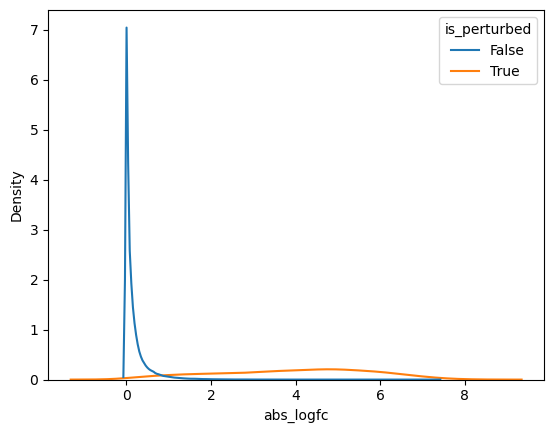

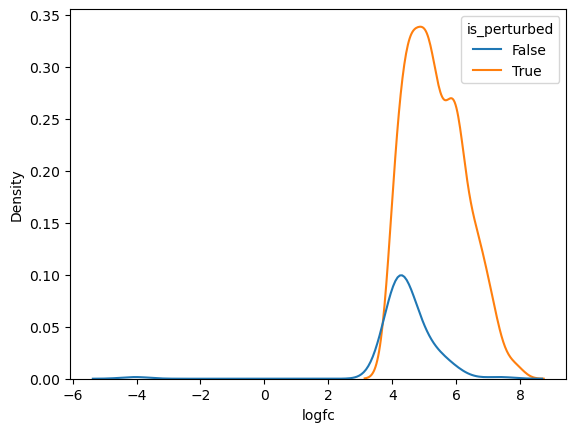

In [34]:
expression_quantified = load_perturbations.load_perturbation("nakatake")
logfc = dict()
for g in expression_quantified.uns["perturbed_and_measured_genes"]:
    logfc[g] = pd.DataFrame(
        {
            "gene": g,
            "perturbation": expression_quantified.obs["perturbation"],
            "logfc": expression_quantified[:,g].X.squeeze() - expression_quantified[expression_quantified.obs["is_control"],g].X.mean(),
        }
    )
    logfc[g]["abs_logfc"] = np.abs(logfc[g]["logfc"])
    logfc[g]["abs_logfc_rank_per_gene"] = logfc[g]["abs_logfc"].rank(ascending = False)
logfc = pd.concat(logfc.values())
logfc["is_perturbed"] = logfc["gene"] == logfc["perturbation"]
print(logfc.query("is_perturbed")["abs_logfc_rank_per_gene"].value_counts().sum())
print(logfc.query("is_perturbed")["abs_logfc_rank_per_gene"].value_counts())
sns.kdeplot(logfc, x = "abs_logfc", hue = "is_perturbed", common_norm = False)
plt.figure()
sns.kdeplot(logfc.query("abs_logfc>log(50)"), x = "logfc", hue = "is_perturbed", common_norm = True)


In [92]:
# All pluripotency-relevant networks
esc_net = pd.concat([
    load_networks.load_grn_by_subnetwork("cellnet_mouse_4302", "esc.parquet") ,
    load_networks.load_grn_by_subnetwork("cellnet_mouse_mogene", "esc.parquet") ,
    load_networks.load_grn_by_subnetwork("cellnet_human_Hg1332", "esc.parquet") ,
    load_networks.load_grn_by_subnetwork("cellnet_human_Hugene", "esc.parquet") ,
    # load_networks.load_grn_by_subnetwork("ANANSE", "hIPS.parquet") ,
    # load_networks.load_grn_by_subnetwork("magnum_compendium_394", "teratocarcinoma_cell_line.parquet") ,
    # load_networks.load_grn_by_subnetwork("csnets", "iPS.parquet") ,
    # load_networks.load_grn_by_subnetwork("csnets", "H9-hESC.parquet") ,
    # load_networks.load_grn_by_subnetwork("csnets", "H7-hESC.parquet") ,
    # load_networks.load_grn_by_subnetwork("csnets", "H1-hESC.parquet") ,
])
logfc["type"] = "other"
logfc.index = range(len(logfc.index))
possible_types = pd.DataFrame({"type": ["other", "direct_target"]}, index = [0,1])
for regulator in set(logfc["perturbation"]):
    direct_targets = set(esc_net.loc[esc_net['regulator']==regulator, "target"])
    pert_matches = regulator == logfc["perturbation"]
    is_direct = logfc.loc[pert_matches, "gene"].isin(direct_targets).astype(int)
    logfc.loc[pert_matches,"type"] = list(possible_types.loc[is_direct, "type"])
    old_regulator = regulator

logfc["type"][logfc["is_perturbed"]] = "perturbed"
logfc["type"].value_counts()

type
other            392254
perturbed           886
direct_target       232
Name: count, dtype: int64

<Axes: xlabel='abs_logfc', ylabel='Density'>

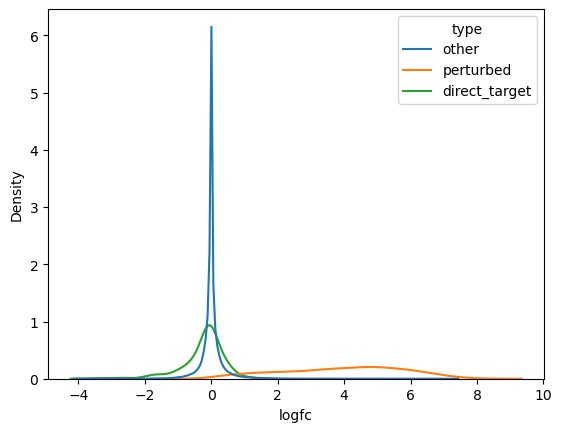

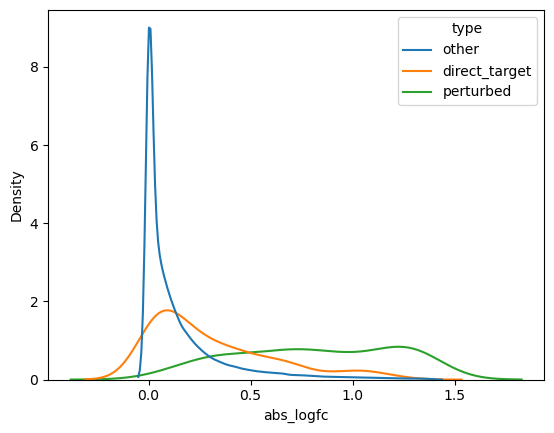

In [91]:
sns.kdeplot(logfc, x = "logfc", hue = "type", common_norm = False)
plt.figure()
sns.kdeplot(logfc.query("abs_logfc < log(4)"), x = "abs_logfc", hue = "type", common_norm = False)
